In [115]:
import pandas as pd
import matplotlib.pyplot as plt
#from benchmarkrewriter.benchmark_parser import WorkerBenchmarkParser
import os

path_to_results = r'C:\Users\huda\Downloads\\'
#path_to_results = r'/home/dhu/Downloads/results/'


In [116]:
ga_path = r'C:\Users\huda\Downloads\ga_worker_results\results.json'
#ga_path = r'/home/dhu/Downloads/results.json'
import json
with open(ga_path, 'r') as f:
    ga_data = json.loads(f.read())

In [117]:
from ast import literal_eval
files = [path_to_results + r'results_ortools.txt', path_to_results +r'results_cplex_cp.txt', path_to_results +r'results_gurobi.txt', path_to_results +r'results_hexaly_rewritten.txt', path_to_results +r'results_cplex_lp_rewritten.txt']
all_data = dict()
data_as_dict = dict()
time_data_as_dict = dict()
for file in files:
    file_content = pd.read_csv(file, names=['name','optimization_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram', 'resource_history', 'best_result_history'], sep=';')#, converters={'best_result_history': pd.eval})
    df = pd.DataFrame(file_content)
    name = file.split('\\')[-1][8:-4]
    if name == 'hexaly_rewritten':
        name = 'hexaly'#all_data['results_hexaly'] = df
    elif name == 'cplex_lp_rewritten':
         name = 'cplex_lp'#all_data['results_cplex_lp'] = df
    all_data[name] = df
    for index, row in df.iterrows():
        if row['name'].startswith('Error'):
            continue
        if name not in data_as_dict:
            data_as_dict[name] = dict()
        data_as_dict[name][row['name'][2:-4]] = row['fitness_value']
        if name not in time_data_as_dict:
            time_data_as_dict[name] = dict()
        #time_data_as_dict[name][row['name'][2:-4]] = row['best_result_history']

        try:
            time_data_as_dict[name][row['name'][2:-4]] = [[float(x.split(',')[0]), int(float(x.split(',')[1][1:]) + 0.5), int(float(x.split(',')[2][1:])) if x.split(',')[2][1:].isnumeric() else int(float(x.split(',')[2][1:-2]))] for x in [r[2:] for r in row['best_result_history'].split('),')[1:]]]
        except:
            continue
del df
del file_content

In [118]:
data_as_dict['ga_best'] = dict()
data_as_dict['ga_average'] = dict()
for key in ga_data.keys():
    entry = ga_data[key]
    data_as_dict['ga_best'][key] = entry['best']
    data_as_dict['ga_average'][key] = entry['average']

In [119]:
def calculate_value(fitness, best):
    return ((fitness - best) / best)

In [178]:
def ecdf_inf(vectors, column, max : bool = False, n_instances : int = 402, labels : list[str] = [], instances : list[str] = [], x_lim = (-0.1, 1.0)):
    
    plot_vectors = []
    for vector in vectors:
        plot_vectors.append([[0.0],[0.0]])
        i = 1
        while i < len(vector):
            if vector[i] == float('inf'):
                break
            if vector[i] == -float('inf'):
                break
            while i < len(vector) and vector[i] == vector[i-1]:
                i += 1
            plot_vectors[-1][0].append(vector[i-1])
            plot_vectors[-1][1].append((i-1)/n_instances)
            i += 1
    for i in range(len(vectors)):
        plt.plot(plot_vectors[i][0], plot_vectors[i][1], label=[labels[i]])
    #if column == 'Fitness Gap to Best':
    plt.xlim(x_lim[0], x_lim[1])
        
    plt.legend()
    plt.title(column)
    plt.show()

In [159]:
plot_data = dict()
best_results = dict()
for key in data_as_dict['ga_best'].keys():
    best = float('inf')
    best_results[key] = best
    plot_data[key] = dict()
    for solver in data_as_dict.keys():
        if key in data_as_dict[solver] and data_as_dict[solver][key] < best:
            best = data_as_dict[solver][key]
            best_results[key] = best
    for solver in data_as_dict.keys():
        if key in data_as_dict[solver]:
            plot_data[key][solver] = calculate_value(data_as_dict[solver][key], best)
        else:
            plot_data[key][solver] = float('inf')

In [160]:
vectors = []
labels = []
for solver in data_as_dict.keys():
    labels.append(solver)
    vector = []
    for instance in data_as_dict['ga_best'].keys():
        vector.append(plot_data[instance][solver])
    vector.sort()
    vectors.append(vector)

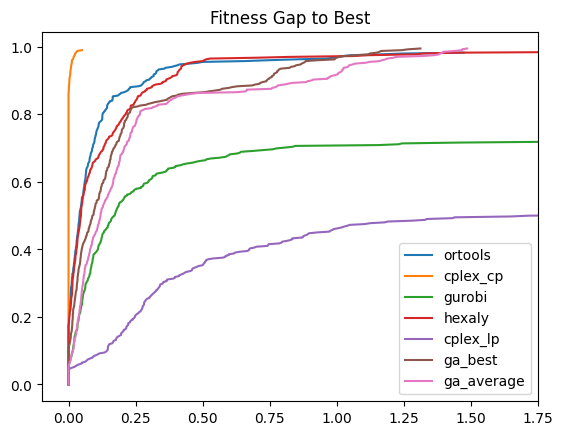

In [191]:
ecdf_inf(vectors, 'Fitness Gap to Best', labels=labels, x_lim=(-0.1, 1.75))

In [162]:
# time data
def get_average_timestamps(average_data, target, max_diff, force_all : bool = False):
    timestamps = dict()
    for instance in average_data:
        timestamps[instance] = []
        for entry in average_data[instance]['all']:
            for i in range(len(entry)):
                if entry[i][1] <= target[instance] * (1.0+max_diff):
                    timestamps[instance].append(entry[i][0])
                    break
        if len(timestamps[instance]) > 0 and (not force_all or (force_all and len(timestamps[instance] == 18))):
            timestamps[instance] = sum(timestamps[instance])/len(timestamps[instance])
        else:
            timestamps.pop(instance)
    return timestamps


In [163]:
#time_path = '/home/dhu/Downloads/timelines.json'
time_path = r'C:\Users\huda\Downloads\ga_worker_results\timelines.json'

In [164]:
import json
with open(time_path, 'r') as f:
    ga_time_data = json.loads(f.read())

In [165]:
ga_best_times = dict()
for instance in ga_time_data:
    ga_best_times[instance] = ga_time_data[instance]['best']

In [166]:
time_data_as_dict['ga_best'] = ga_best_times

In [167]:
def get_timestamps(data, targets, max_diff, best : bool = False):
    timestamps = dict()
    labels = []
    for solver in data:
        labels.append(solver)
        if solver not in timestamps:
            timestamps[solver] = []
        for instance in data[solver]:
            for entry in data[solver][instance]:
                #for i in range(len(entry)):
                    if instance in targets[solver]:
                        if best:
                            if entry[1] <= (targets['best'][instance] * (1.0+max_diff)):
                                timestamps[solver].append(entry[0])
                                break
                        else:
                            if entry[1] <= (targets[solver][instance] * (1.0+max_diff)):
                                timestamps[solver].append(entry[0])
                                break
    for solver in timestamps:
        timestamps[solver].sort()
    return timestamps, labels

In [168]:
import matplotlib.pyplot as plt
def ecdf_inf(data, title, n_instances : int = 402, labels : list[str] = []):
    plot_vectors = []
    for vector in data:
        plot_vectors.append([[0.0],[0.0]])
        i = 1
        while i < len(vector):
            if vector[i] == float('inf'):
                break
            if vector[i] == -float('inf'):
                break
            while i < len(vector) and vector[i] == vector[i-1]:
                i += 1
            plot_vectors[-1][0].append(vector[i-1])
            plot_vectors[-1][1].append((i-1)/n_instances)
            i += 1
    for i in range(len(data)):
        plt.plot(plot_vectors[i][0], plot_vectors[i][1], label=[labels[i]])
    plt.title(title)
    plt.legend()
    plt.show()


In [169]:
max_diff = 0.1

In [170]:
def extract_best(data):
    result = dict()
    result['best'] = dict()
    for solver in data:
        result[solver] = dict()
        for instance in data[solver]:
            result[solver][instance] = data[solver][instance]
            if not instance in result['best']:
                result['best'][instance] = float('inf')
            if data[solver][instance] < result['best'][instance]:
                result['best'][instance] = data[solver][instance]
    return result

In [171]:
best_results_all = extract_best(data_as_dict)
timestamps = get_average_timestamps(ga_time_data, data_as_dict['ga_best'], max_diff)
all_timestamps, labels = get_timestamps(time_data_as_dict, best_results_all, max_diff)
all_timestamps['ga_average'] = sorted([timestamps[key] for key in timestamps])
labels.append('ga_average')

In [172]:
plot_data = []
labels = []
for key in all_timestamps:
    plot_data.append(all_timestamps[key])
    labels.append(key)

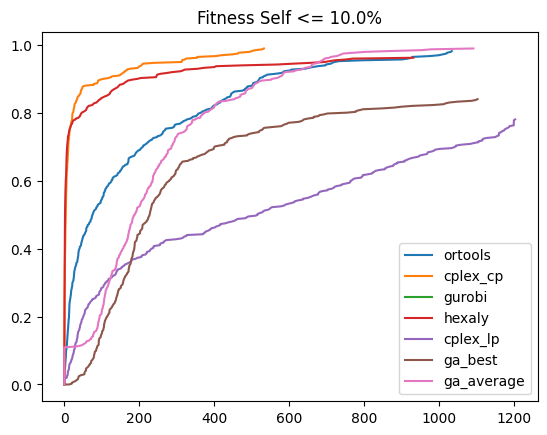

In [173]:
ecdf_inf(plot_data, f'Fitness Self <= {max_diff*100}%', labels=list(labels))

In [174]:
timestamps = get_average_timestamps(ga_time_data, best_results, max_diff)
all_timestamps, labels = get_timestamps(time_data_as_dict, best_results_all, max_diff, True)
all_timestamps['ga_average'] = sorted([timestamps[key] for key in timestamps])
labels.append('ga_average')

In [175]:
plot_data = []
labels = []
for key in all_timestamps:
    plot_data.append(all_timestamps[key])
    labels.append(key)

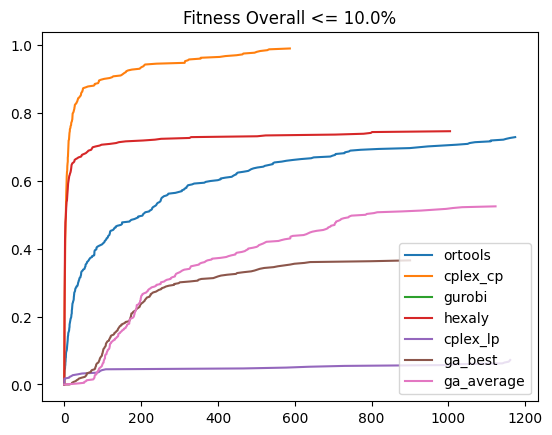

In [176]:
ecdf_inf(plot_data, f'Fitness Overall <= {max_diff*100}%', labels=list(labels))
